In [1]:
import pandas   as pd
import numpy    as np
import datetime as dt
import seaborn  as sns

import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats.stats import pearsonr

# Read all the datasets in csv files
erp_df   = pd.read_csv("ERP.csv")
dss_df   = pd.read_csv("DSSPayment.csv")
crime_df = pd.read_csv("CrimeRate2016.csv")

# Set a standard for datetime format
FMT = '%Y-%m'

In [2]:
########## Pre-processing DSS Payment Dataset ##########

# Since data DSS DF is recorded quarterly from 2016 to 2017
# It is required to filter out data that is not recorded in 2016

# Set a datetime value with the standardized format
date = "2017-01"
newdate = dt.datetime.strptime(date, "%Y-%m") 

# Find all the LGA Code in Victoria and along with max/min Code index using Crime Df for easier integration with DSS Df
vicLGACode = sorted([lga_code for lga_code in crime_df[' lga_code']])
maxLGACode = max(vicLGACode)
minLGACode = min(vicLGACode)

# Only select the data in dss_df that has the Victoria LGA Code
dss_df = dss_df.loc[(dss_df['LGA_Code_2014'] >= minLGACode) & (dss_df['LGA_Code_2014'] <= maxLGACode)]

# Reformat the 'date' column values to compatible datetime format
dss_df['date'] = pd.to_datetime(dss_df['date'], format = FMT)

# Select only the data in year 2016
dss_df = dss_df[(dss_df['date'] < newdate)]

# Find the area using the Vic LGA Code of Crime Df for easier integration
dss_df = dss_df[dss_df.LGA_Code_2014.isin(vicLGACode)]

# Since there are 4 records for each LGA code, the average is taken to produce 1 record for each LGA Code
grouped_dss_df = dss_df.groupby('LGA_Code_2014').mean()

# Drop the empty column
grouped_dss_df = grouped_dss_df.drop('Widow B Pension', 1)

### Note that it's no missing values in Dss df so it can be ignored for now

print(grouped_dss_df.shape)
grouped_dss_df.head()

(79, 25)


,ABSTUDY (Living allowance),ABSTUDY (Non-living allowance),Age Pension,Austudy,Carer Allowance,Carer Allowance (Child Health Care Card only),Carer Payment,Commonwealth Seniors Health Card,Disability Support Pension,Family Tax Benefit A,...,Parenting Payment Single,Partner Allowance,Pensioner Concession Card,Sickness Allowance,Special Benefit,Widow Allowance,Wife Pension (Partner on Age Pension),Wife Pension (Partner on Disability Support Pension),Youth Allowance (other),Youth Allowance (student and apprentice)
LGA_Code_2014,,,,,,,,,,,,,,,,,,,,,
20110,1.25,0.00,2171.25,12.75,339.00,7.25,138.50,285.25,425.75,798.25,...,103.25,5.00,3048.00,3.75,1.25,10.75,5.00,6.00,27.50,42.50
20260,1.25,0.00,1886.25,11.25,364.00,12.50,165.00,199.25,664.25,810.00,...,134.00,0.00,3123.75,2.50,0.00,8.50,3.75,5.00,80.25,37.50
20570,25.75,35.75,12581.25,289.25,3296.25,117.25,1512.75,1039.00,5271.75,7906.00,...,1568.50,24.25,23039.25,49.00,5.00,89.75,29.25,25.25,785.75,1898.25
20660,16.75,14.75,13171.50,257.00,2958.50,96.75,887.50,2314.25,3390.00,5655.00,...,709.50,8.00,19535.50,39.25,27.50,84.00,23.00,10.50,262.25,1316.25
20740,2.50,6.50,6423.50,43.25,1052.75,21.75,432.50,753.75,1650.50,2540.00,...,445.25,9.75,9831.50,13.75,0.00,32.00,12.50,15.25,139.75,114.75


In [3]:
########## Integrations of datasets for initial investigation ##########

### Since Crime df already has total offence count
### So it is no need to pre-process it

# Initialize new dataframe
filtered_df = pd.DataFrame()

# Sum up all the values of each column of each row to get the total DSS Payments Recipients for each LGA Code
filtered_df['Total DSS Payments Recipients'] = grouped_dss_df.iloc[:, 1:-1].sum(axis=1)

# Initialize column 'Grand Total Offence Count' in filtered_df
filtered_df['Grand Total Offence Count'] = 0

# Since LGA Code for each row of records is not in any particular order (Ascending/Descending)
# Values of column 'grand_total_offence_count' need to be extracted and transferred to the filtered_df accordingly 
for code in vicLGACode:
    val = crime_df[' grand_total_offence_count'].loc[crime_df[' lga_code'] == code].values
    filtered_df.at[code, 'Grand Total Offence Count'] =  val
    

In [4]:
########## Pre-processing ERP Dataset for Dataframe normalization ##########

# filter out estimated resident population df with Victoria LGA code only
erp_df = erp_df.loc[(erp_df['LGA_2016'] >= minLGACode) & (erp_df['LGA_2016'] <= maxLGACode)]

# Select values of erp_df in year 2016 only
erp_df = erp_df.loc[erp_df.TIME == 2016]

# Initialize column 'Estimated Resident Population (ERP)' in filtered_df
filtered_df['Estimated Resident Population (ERP)'] = 0

# Since LGA Code for each row of records is not in any particular order (Ascending/Descending)
# Values of column ERP need to be extracted and transferred to the filtered_df accordingly 
for code in vicLGACode:
    val = erp_df['Value'].loc[erp_df['LGA_2016'] == code].values
    filtered_df.at[code, 'Estimated Resident Population (ERP)'] =  val
    

In [5]:
########## Normalization of DataFrame ##########

# Initialize normalized_df
normalized_df = pd.DataFrame()

# Normalize filtered_df by ERP dataset and transfer the normalized values to normalized_df
normalized_df['Normalized Total DSS Payments Recipients'] = filtered_df.apply(lambda row: row['Total DSS Payments Recipients'] / row['Estimated Resident Population (ERP)'] * 100, axis=1)
normalized_df['Normalized Grand Total Offence Count'] = filtered_df.apply(lambda row: row['Grand Total Offence Count'] / row['Estimated Resident Population (ERP)'] * 100, axis=1)


Pearson correlation coefficient = 0.0351 


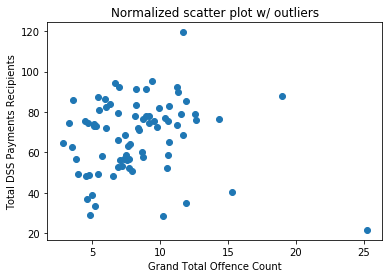

In [6]:
########## Scatter plot for normalized_df ##########
plt.clf

plt.scatter(normalized_df['Normalized Grand Total Offence Count'], normalized_df['Normalized Total DSS Payments Recipients'])
plt.title("Normalized scatter plot w/ outliers")
plt.xlabel('Grand Total Offence Count')
plt.ylabel('Total DSS Payments Recipients')

# Print Pearson correlation coefficient
print("Pearson correlation coefficient = %0.4f " %(normalized_df['Normalized Grand Total Offence Count'].corr(normalized_df['Normalized Total DSS Payments Recipients'])))    

In [7]:
########## Finding the pearson correlation for the data gathered (w/ outliers) ##########
xi = []
yi = []

for i in range(len(normalized_df)):
    xi.append(normalized_df.iloc[i]['Normalized Grand Total Offence Count'])
    yi.append(normalized_df.iloc[i]['Normalized Total DSS Payments Recipients'])
    
# Finding pearson correlation    
pearson_r, p_value = pearsonr(xi,yi)    

print("Pearson correlation coefficient w/ outliers = %.5f" %(pearson_r))

Pearson correlation coefficient w/ outliers = 0.03514


In [8]:
########## Finding the pearson correlation for the data gathered (w/o outliers) ##########
s = pd.Series(xi)

# Find Interquartile range(IQR) for the dataset
q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3-q1

processed_xi = []
processed_yi = []

# Remove outliers (Suspected outliers)
for i in range(len(xi)):
    if (xi[i] < (iqr*1.5 + q3)):
        processed_xi.append(xi[i])
        processed_yi.append(yi[i])

# Finding pearson correlation        
pearson_r, p_value = pearsonr(processed_xi, processed_yi)    

print("Pearson correlation coefficient w/o outliers = %.5f" %(pearson_r))

Pearson correlation coefficient w/o outliers = 0.20741


Pearson correlation is  0.20741495164835208


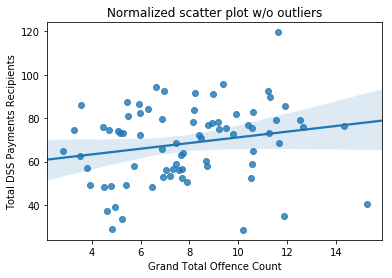

In [9]:
########## Plot regression line for the dataset ########## 
processed_df = pd.DataFrame()

processed_df['Grand Total Offence Count'] = processed_xi
processed_df['Total DSS Payments Recipients'] = processed_yi

# Plot the regression line using regplot method in the seaborn library
r = sns.regplot(processed_df['Grand Total Offence Count'], processed_df['Total DSS Payments Recipients'])
r.set_title("Normalized scatter plot w/o outliers")

print("Pearson correlation is ", processed_df['Grand Total Offence Count'].corr(processed_df['Total DSS Payments Recipients']))

In [10]:
########## End of initial investigation ##########

In [11]:
##### Function to find all columns of a dataframe that contains at least 1 missing value #####
def find_nan_columns(df):
    
    columns_list = []

    # Traverse throught individual column to find missing value
    for column in df.columns:
        is_there_NaN = False
        
         # If one missing value is found then the loop skips the column to the next one
        for value in df[column]:
            if np.isnan(value):
                is_there_NaN = True
                break
        # If missing value(s) is found in the column, its name is then append to a list
        if is_there_NaN:
            columns_list.append(column)  
    
    # return all the columns name in a list
    return columns_list
        

In [12]:
########## Pre-processing Crime Df for further investigation ########## 

# Read the file directly to make sure crime_df gets a complete copy of the file every time it runs
crime_df = pd.read_csv("CrimeRate2016.csv")

# Set the LGA Code as the new index system
crime_df.set_index(keys=' lga_code', inplace=True)

# Sort the records accordingly using LGA Code in ascending order
crime_df = crime_df.sort_index()

# Drops all the unrequired columns
crime_df = crime_df.drop(' lga_name11', 1)
crime_df = crime_df.drop(' lga_erp', 1)
crime_df = crime_df.drop(' reference_period', 1)

### Handles missing values
# Find all columns that contain at least 1 Nan value(missing value)
nan_columns_list = find_nan_columns(crime_df)

# Remove columns that are found to have contained at least 1 missing value
for column in nan_columns_list:
    crime_df = crime_df.drop(column, 1)    
    
# Print the shape of the processed crime df in form of (row, columns)
print(crime_df.shape)
crime_df.head()

(79, 21)


,grand_total_offence_count,total_division_c_offences,d20_disorderly_&_offensive_conduct,d10_weapons_&_explosives_offences,a80_dangerous_&_negligent_acts_endangering_people,a30_sexual_offences,e10_justice_procedures,total_division_f_offences,b50_deception,a20_assault_&_related_offences,...,b20_property_damage,total_division_a_offences,d30_public_nuisance_offences,total_division_d_offences,b30_burglary_break_&_enter,total_division_b_offences,total_division_e_offences,e20_breaches_of_orders,a70_stalking_harassment_&_threatening_behaviour,b40_theft
lga_code,,,,,,,,,,,,,,,,,,,,,
20110,407,27,34,26,4,32,1,8,12,51,...,36,104,3,63,29,158,47,46,17,79
20260,1243,123,87,45,20,36,81,4,50,169,...,141,260,16,148,72,455,253,172,33,185
20570,11956,498,279,343,125,544,424,32,695,931,...,1212,1784,41,664,1245,7363,1615,1191,130,4058
20660,9806,476,166,205,76,175,223,16,712,715,...,774,1236,61,434,1155,6154,1490,1267,214,3453
20740,2989,122,99,89,60,115,105,9,119,337,...,323,620,24,212,218,1434,592,487,98,736


In [13]:
########## Transferring Data to new DataFrames for easier recognition of dataframes ########## 

# Initialize new DataFrames
processed_crime_df = pd.DataFrame()
processed_dss_df = pd.DataFrame()

# Transferring data to new DataFrames
processed_crime_df = crime_df
processed_dss_df = grouped_dss_df

In [14]:
########## Normalization of DataFrames ##########

# Create new column ERP for both datasets 
processed_dss_df['Estimated Resident Population (ERP)'] = 0
processed_crime_df['Estimated Resident Population (ERP)'] = 0

# Assign values of ERP accordingly to LGA Code
for code in vicLGACode:
    val = erp_df['Value'].loc[erp_df['LGA_2016'] == code].values
    processed_dss_df.at[code, 'Estimated Resident Population (ERP)'] =  val
    processed_crime_df.at[code, 'Estimated Resident Population (ERP)'] =  val

# Create new dataframes to store normalized values of both dataframes
normalized_dss_df = pd.DataFrame()
normalized_crime_df = pd.DataFrame()

# Normalizing at work!
# Both dataframes are normalized using the value in ERP column with respect to LGA Code
for i in processed_dss_df.columns:
    normalized_dss_df[i] = processed_dss_df.apply(lambda row: row[i]/ row['Estimated Resident Population (ERP)'] * 100, axis = 1)

for i in processed_crime_df.columns:
    normalized_crime_df[i] = processed_crime_df.apply(lambda row: row[i]/ row['Estimated Resident Population (ERP)'] * 100, axis = 1)

# Drop the ERP columns as they are no longer required    
normalized_crime_df = normalized_crime_df.drop('Estimated Resident Population (ERP)', 1)
normalized_dss_df = normalized_dss_df.drop('Estimated Resident Population (ERP)', 1)

In [15]:
########## Finding Pearson Correlations for all attributes in both datasets ##########

### For each column of processed_dss_df, finds its pearson correlation with all other columns of processed_crime_df
### Hence, more interesting results/correlations can be found

# Get new list to store all the correlations
pearson_r_list = []

# For each type of crime/offence, find its corresponding pearson correlation with each type of DSS Payment
for i in range(len(normalized_crime_df.columns)):
    for j in range(len(normalized_dss_df.columns)):
        pearson_r_list.append(normalized_crime_df[normalized_crime_df.columns[i]].corr(normalized_dss_df[normalized_dss_df.columns[j]]))

        
# Reshape the pearson_arrays to 2D arrays, with each array inside the Big Array representing a type of crime
# and each value in it representing a pearson correlation value with each type of DSS Payment
# Hence 21 arrays(Type of Crimes) in total, and each containing 25 float values(Pearson Correlations with each type of DSS Payment)
pearson_arrays = ((np.asarray(pearson_r_list)).reshape(21,25))
print(pearson_arrays)

[[ 0.41103654  0.19361943 -0.21129097  0.35939817  0.06433988  0.15256603
   0.15669034 -0.42981568  0.21448883  0.04149503  0.13551869  0.32019665
   0.35724759  0.3868193   0.26727279  0.34178061 -0.05317715 -0.0345596
   0.10028259  0.20597998  0.07135099 -0.02524704  0.06501305  0.43045643
   0.40824592]
 [ 0.27874398  0.18159929 -0.12048778  0.23711718  0.08657156  0.15101165
   0.15123622 -0.40848242  0.25997314  0.11393442  0.16288761  0.30172166
   0.28414575  0.38169851  0.25896779  0.31032795 -0.09763956  0.04082441
   0.05947924  0.17460404  0.0928777   0.04675767  0.11986283  0.40839995
   0.25001276]
 [ 0.30717512  0.16480785 -0.11636691  0.15171422 -0.15774109 -0.0761754
  -0.06142009 -0.18419692  0.14037731 -0.11278454 -0.08352742  0.02194917
   0.05135442  0.16211684  0.02829574  0.11337787 -0.07845028 -0.03333914
  -0.04978562  0.05012978 -0.0021163  -0.06678302  0.0244335   0.21567522
   0.14674737]
 [ 0.32099153  0.38601922  0.14449429 -0.05005581  0.32502792  0.3329

In [16]:
########## Find the maximum mean among the 21 arrays ##########

# Initialize all the required variables
max_mean  = 0
max_value = 0

max_mean_index  = 0
max_value_index = 0

# Traverse through all the arrays then retain the required information
for i in range(len(pearson_arrays)):
    
    # Record the max_mean value and its index position
    # if the mean of the selected array is bigger than the previously recorded max_mean value
    if (np.mean(pearson_arrays[i]) > max_mean):
        max_mean = np.mean(pearson_arrays[i])
        max_mean_index = i
    
    # Record the max value found in any array and its index position
    if (max(pearson_arrays[i]) > max_value):
        max_value = max(pearson_arrays[i])
        max_value_index = i

# Get the index position of the max value in the array where it's located at
max_value_column_index = (pearson_arrays[max_value_index].tolist()).index(max_value)        

In [17]:
# Prints out the recorded maximum values
print("Max mean  = %f, found at index %d in array" %(max_mean, max_mean_index))
print("Column = %s" %(normalized_crime_df.columns[max_mean_index]))
print(pearson_arrays[max_mean_index])

print("\nMax value = %f, found at index %d in array at column %d" %(max_value, max_value_index, max_value_column_index))
print("Column = %s " %(normalized_crime_df.columns[max_value_index]))
print(pearson_arrays[max_value_index])

Max mean  = 0.321354, found at index 12 in array
Column =  total_division_a_offences
[ 0.34091586  0.42314302  0.19970229 -0.13897007  0.40445279  0.42114383
  0.44756656 -0.28253875  0.59261882  0.40170643  0.43567072  0.52291147
  0.23994614  0.6241881   0.43008426  0.63101768  0.15114407  0.39668123
  0.35450915 -0.09376573  0.29063255  0.23111468  0.35941214  0.71565247
 -0.06508885]

Max value = 0.722785, found at index 17 in array at column 23
Column =  total_division_e_offences 
[ 0.29247673  0.37433587  0.14687272 -0.08091916  0.3667995   0.4602407
  0.39144927 -0.33813719  0.51073292  0.41288637  0.46904126  0.54687783
  0.36561147  0.58728498  0.45398557  0.64468713  0.10181506  0.3345552
  0.36207709 -0.04849961  0.25540535  0.16379523  0.28021746  0.72278502
  0.03033153]


Pearson correlation is  0.7227850212884126


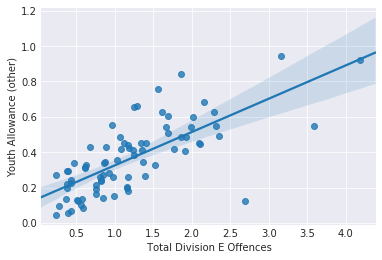

In [18]:
# Print out scatter plot and its regression line along with its pearson correlation
max_crime_column = normalized_crime_df.columns[max_value_index]
max_dss_column = normalized_dss_df.columns[max_value_column_index]


with sns.axes_style("darkgrid"):
    r = sns.regplot(normalized_crime_df[max_crime_column], normalized_dss_df[max_dss_column])
    r.set(xlabel=max_crime_column.replace("_"," ").title())

print("Pearson correlation is ", normalized_crime_df[max_crime_column].corr(normalized_dss_df[max_dss_column]))

In [19]:
########## Find the minimum mean among the 21 arrays ##########

# Initialize all the required variables
min_mean  = 0
min_value = 0

min_mean_index  = 0
min_value_index = 0

# Traverse through all the arrays then retain the required information
for i in range(len(pearson_arrays)):
    
    # Record the min_mean value and its index position
    # if the mean of the selected array is bigger than the previously recorded min_mean value
    if (np.mean(pearson_arrays[i]) < min_mean):
        min_mean = np.mean(pearson_arrays[i])
        min_mean_index = i
    
    # Record the min value found in any array and its index position
    if (min(pearson_arrays[i]) < min_value):
        min_value = min(pearson_arrays[i])
        min_value_index = i

# Get the index position of the min value in the array where it's located at
min_value_column_index = (pearson_arrays[min_value_index].tolist()).index(min_value)      

In [20]:
# Prints out the recorded minimum values
print("Min mean  = %f, found at index %d in array" %(min_mean, min_mean_index))
print("Column = %s" %(normalized_crime_df.columns[min_mean_index]))
print(pearson_arrays[min_mean_index])

print("\nMin value = %f, found at index %d in array at column %d" %(min_value, min_value_index, min_value_column_index))
print("Column = %s " %(normalized_crime_df.columns[min_value_index]))
print(pearson_arrays[min_value_index])

Min mean  = -0.094491, found at index 8 in array
Column =  b50_deception
[ 0.36239604 -0.11810469 -0.46339577  0.51823124 -0.34946982 -0.17568451
 -0.23618306 -0.30746758 -0.22145199 -0.35084563 -0.27298978 -0.10607361
  0.1879598  -0.10102066 -0.10170889 -0.13004309 -0.15551591 -0.40575948
 -0.18917435  0.35485487 -0.1490918  -0.2326793  -0.22550627 -0.07263884
  0.5790945 ]

Min value = -0.537559, found at index 20 in array at column 2
Column =  b40_theft 
[ 0.32034878 -0.10222768 -0.53755899  0.72236699 -0.24848844 -0.19158091
 -0.13382025 -0.41372453 -0.21769942 -0.32948287 -0.21291398  0.01543646
  0.31025798  0.03274687  0.02749993 -0.08528775 -0.21761645 -0.43760357
 -0.17066312  0.43252901 -0.15660752 -0.23204686 -0.23586203 -0.02411992
  0.71537228]


Pearson correlation is  -0.5375589872312175


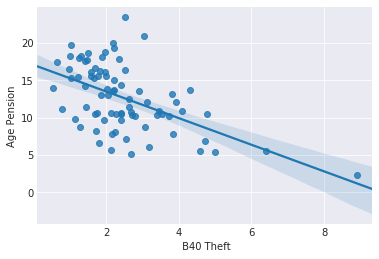

In [21]:
# Print out scatter plot and its regression line along with its pearson correlation
min_crime_column = normalized_crime_df.columns[min_value_index]
min_dss_column = normalized_dss_df.columns[min_value_column_index]

with sns.axes_style("darkgrid"):
    r = sns.regplot(normalized_crime_df[min_crime_column], normalized_dss_df[min_dss_column])
    r.set(xlabel=min_crime_column.replace("_"," ").title())

print("Pearson correlation is ", normalized_crime_df[min_crime_column].corr(normalized_dss_df[min_dss_column]))

In [22]:
########## Generate a Heatmap for all the pearson correlations found ##########

# Create new dataframe to store the required data only
pearson_df = pd.DataFrame()

# Create new column with all DSS columns name as its value
pearson_df['DSS Columns'] = normalized_dss_df.columns

# Set new indexing system of the dataframe using the DSS columns name 
# So each row represents a type of DSS Payments
pearson_df.set_index(keys= 'DSS Columns', inplace=True)

# Initialize new Index variable to index normalized_crime_df column position 
index = 0

### Renaming columns to be more human-readable
# Initialize new list to store all Renamed Columns
processed_columns_list = []

# Traverse through each column and tweak its name 
for column in normalized_crime_df.columns:
    column = column.replace("_", " ")
    processed_columns_list.append(column.title()[1:]) 

# Since each array in the pearson_arrays represents a kind of crime/offence
# Hence the values of each array are inserted accordingly into each newly renamed column of the dataframe
for array in pearson_arrays:
    pearson_df[processed_columns_list[index]] = array
    index += 1

print(pearson_df.shape)
#pearson_df.head()

(25, 21)


[Text(69,0.5,''), Text(0.5,51,'')]

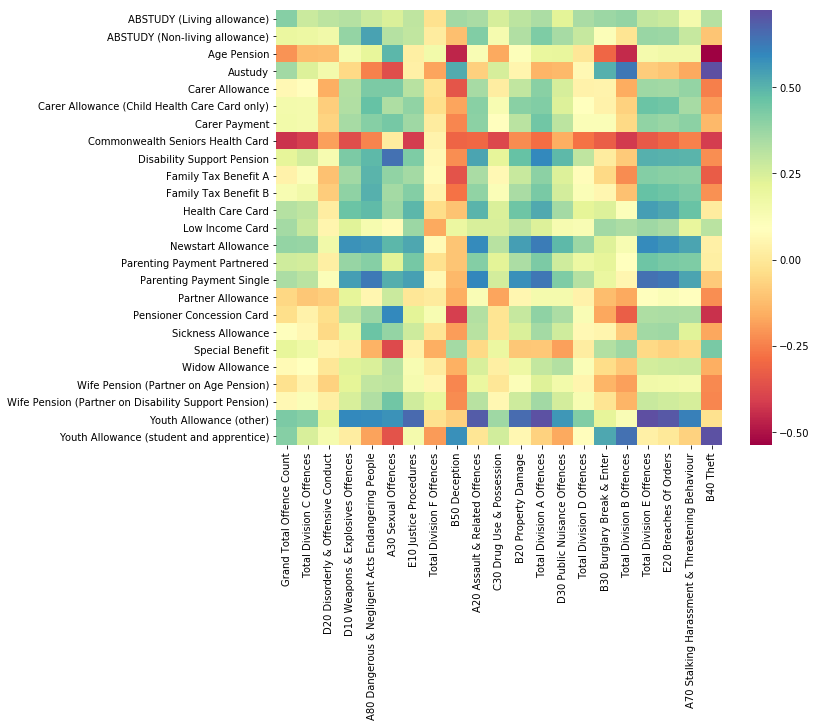

In [23]:
########## Generating a Heatmap ##########

# Set the size of the heatmap
fig, ax = plt.subplots(figsize=(10,8))

# Initialize variables to store different color scheme
color_scheme1 = 'viridis'
color_scheme2 = 'Spectral'
color_scheme3 = 'nipy_spectral_r'

# Codes of creating the heatmap #
r = sns.heatmap(pearson_df, cmap=color_scheme2)
#r.set_title("Heatmap of All Pearson Correlation Coefficients")
r.set(xlabel='', ylabel='')

In [24]:
########## Find the maximum average pearson correlation among the types of DSS Payments ##########

max_mean = 0
index = 0

for i in range(len(pearson_df)):
    if (max_mean < pearson_df.iloc[i].mean()):
        max_mean = pearson_df.iloc[i].mean()
        index = i
    
print(max_mean)

0.43460856519394586


In [25]:
########## Find the minimum average pearson correlation among the types of DSS Payments ##########

min_mean = 0
index = 0

for i in range(len(pearson_df)):
    if (min_mean > pearson_df.iloc[i].mean()):
        min_mean = pearson_df.iloc[i].mean()
        index = i
    
print(min_mean)           

-0.2829360316792869


In [26]:
########## Select DSS Payments that have similar patterns of pearson correlations ##########

similar_df = pearson_df.loc[['Carer Allowance', 'Carer Allowance (Child Health Care Card only)', 'Carer Payment', \
                 'Family Tax Benefit A', 'Family Tax Benefit B', 'Newstart Allowance', 'Parenting Payment Single', \
                 'Sickness Allowance', 'Widow Allowance', 'Wife Pension (Partner on Age Pension)', \
                 'Wife Pension (Partner on Disability Support Pension)']]


[Text(69,0.5,''), Text(0.5,15,'')]

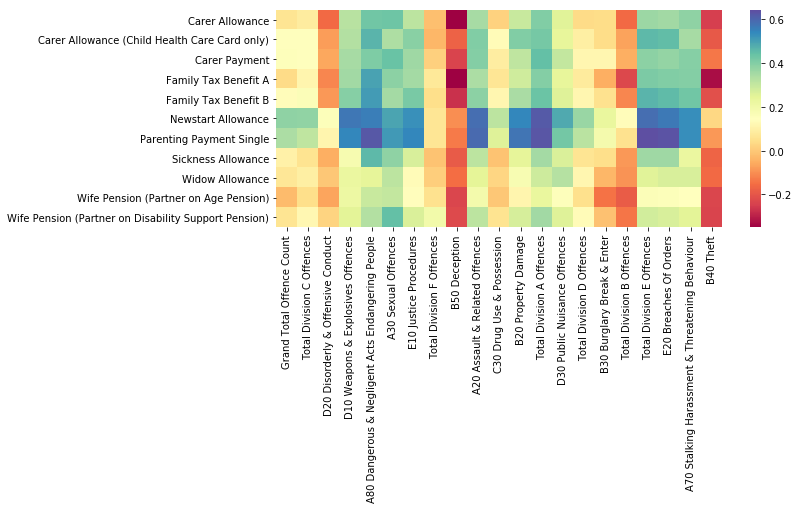

In [27]:
########## Generating a Heatmap for selected DSS Payments ##########

# Set the size of the heatmap
fig, ax = plt.subplots(figsize=(10,4))

# Initialize variables to store different color scheme
color_scheme1 = 'viridis'
color_scheme2 = 'Spectral'
color_scheme3 = 'nipy_spectral_r'

# Codes of creating the heatmap #
r = sns.heatmap(similar_df, cmap=color_scheme2)
r.set(xlabel='', ylabel='')

Pearson correlation is  0.6467334002518121


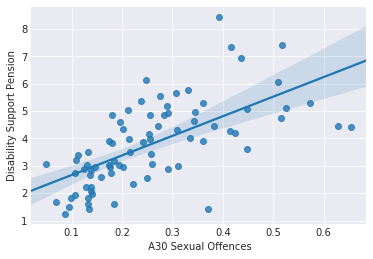

In [28]:
########## Arbitrarily select a DSS Payment that has an interesting correlation ##########

# Disability Support Pension and A30 Sexual Offences are selected
with sns.axes_style("darkgrid"):
    r = sns.regplot(normalized_crime_df[' a30_sexual_offences'], normalized_dss_df['Disability Support Pension'])
    r.set(xlabel=' a30_sexual_offences'.replace("_"," ").title())
    
print("Pearson correlation is ", normalized_crime_df[' a30_sexual_offences'].corr(normalized_dss_df['Disability Support Pension']))    

Pearson correlation is  -0.40575948335543244


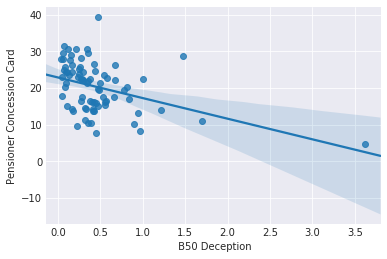

In [29]:
########## Arbitrarily select a DSS Payment that has an interesting correlation ##########

# Pensioner Concession Card and B50 Deception are selected
with sns.axes_style("darkgrid"):
    r = sns.regplot(normalized_crime_df[' b50_deception'], normalized_dss_df['Pensioner Concession Card'])
    r.set(xlabel=' b50_deception'.replace("_"," ").title())
    

print("Pearson correlation is ", normalized_crime_df[' b50_deception'].corr(normalized_dss_df['Pensioner Concession Card']))    